# Demo_Hough_Circles_ 2




**Author:** Lailin XU  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Monday, April 11, 2022 at 12:11 AM.</small></i>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ROOT as R
from math import fabs

Assertion failed: p_rcu_reader->depth != 0 (/qemu/include/qemu/rcu.h: rcu_read_unlock: 101)
ldd: exited with unknown exit code (134)


Welcome to JupyROOT 6.26/00


Hit positions

In [2]:
xHits=[]
yHits=[]
layerId=[]

3 layers of cylindrical pixel detectors, with the following radius (mm)

In [3]:
detR=[65.115, 115.11, 165.11]

Read hits from a TTree file

Each event has only one track. For the purpose of this tutorial, one can read more than one track. 

In [4]:
def readHits(infile, nTrks):

  xHits=[]
  yHits=[]
  layerId=[]

  tf=R.TFile.Open(infile, "READ")
  tr=tf.Get("tree1")
  nevents=tr.GetEntries()

  itrk=0
  for i in range(nevents):
    tr.GetEntry(i)
    x = tr.posX
    y = tr.posY
    l = tr.layerID
    # the first 3 hits
    for j in range(3):
      xHits.append(x[j])     
      yHits.append(y[j])     
      layerId.append(l[j])     

    itrk+=1
    if itrk >= nTrks: break
  
  return [xHits, yHits, layerId]

Conformal mapping

In [5]:
def conformal(xHits, yHits):

  cxHits, cyHits=[], []
  for x, y in zip(xHits, yHits):
    if x==0 and y==0:
      print("Error! wrong hits")
      continue
    cx=2 * x / (x * x + y * y) 
    cy=2 * y / (x * x + y * y) 

    cxHits.append(cx)
    cyHits.append(cy)

  return [cxHits, cyHits]

Generate randome noise hits

In [6]:
def addNoise(nNoise):

    xNoise, yNoise, lNoise=[], [], []
    for i in range(nNoise):
      # a random hit in the detector surface 
      theta=np.random.rand()
      # pick a random detector layer
      layerId=int(np.random.rand()*100%3)
      r = detR[layerId]
      x, y = r * np.cos(theta), r * np.sin(theta)
      xNoise.append(x)
      yNoise.append(y)
      lNoise.append(layerId)
      

    return [xNoise, yNoise, lNoise]

Hough transform

In [7]:
def houghLine(xHits, yHits):
    ''' Basic Hough line transform that builds the accumulator array
    Input : xHits, yHits are x and y coodinates of all points
    Output : accumulator : the accumulator of hough space
             thetas : values of theta (-90 : 90)
             rs : values of radius (-max distance : max distance)
    Reference: https://sbme-tutorials.github.io/2018/cv/notes/5_week5.html
    '''

    # Get image dimensions
    # y for rows and x for columns 
    Ny = len(yHits)
    Nx = len(xHits)

    # Binning
    Maxdist = 100

    # Theta in range from -90 to 90 degrees
    thetas = np.deg2rad(np.arange(-90, 90))
    # Range of radius
    rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist)
    rmin, rmax = 1e6, -1e6
    # Loop all points of the image
    for x, y in zip(xHits, yHits):
        # Map edge pixel to hough space
        for k in range(len(thetas)):
           # Calculate space parameter
           r = x*np.cos(thetas[k]) + y * np.sin(thetas[k])
           if r > rmax: rmax=r
           if r < rmin: rmin=r
    rstep = (rmax-rmin)/(Maxdist*2)

    accumulator = np.zeros((2 * Maxdist, len(thetas)))

    # Loop all points of the image
    for x, y in zip(xHits, yHits):
        # Map edge pixel to hough space
        for k in range(len(thetas)):
           # Calculate space parameter
           r = x*np.cos(thetas[k]) + y * np.sin(thetas[k])

           # Update the accumulator
           # N.B: r has value -max to max
           # map r to its idx 0 : 2*max
           #accumulator[int((r-rmin)/rstep) + Maxdist,k] += 1
           rind = int((r-rmin)/rstep)
           if rind < Maxdist*2:
             accumulator[rind,k] += 1

    return accumulator, thetas, rs

Read hits
==========

A Ntuple containning hit positions in 3 detector layers. Hits are generated with 100 MeV electrons in the Super Tau-Charm Factory detector.

In [8]:
infile="posPt100.root"

Number of tracks to test

In [9]:
nTrks=2
[xHits, yHits, layerId] = readHits(infile, nTrks)

Generate noise hits
==========

In [10]:
nNoise=2
[xNoise, yNoise, lNoise] = addNoise(nNoise)
xHitsSig=list(xHits)
yHitsSig=list(yHits)
xHits.extend(xNoise)
yHits.extend(yNoise)
layerId.extend(lNoise)

Plotting
==========

(-173.36550000000003, 173.36550000000003)

<Figure size 1080x324 with 0 Axes>

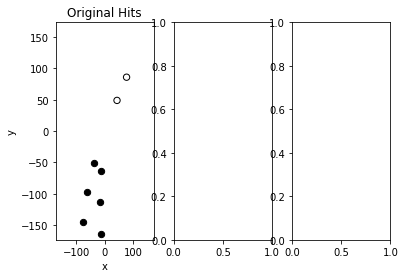

In [11]:
plt.figure('Hits', figsize=(15,4.5))
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
plt.subplot(1,3,1)
plt.title('Original Hits')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(xHitsSig, yHitsSig, s=40, color='black')
plt.scatter(xNoise, yNoise, s=40, facecolors='none', edgecolor='black')

plt.xlim((-detR[2]*1.05,detR[2]*1.05))
plt.ylim((-detR[2]*1.05,detR[2]*1.05))

The central collision point

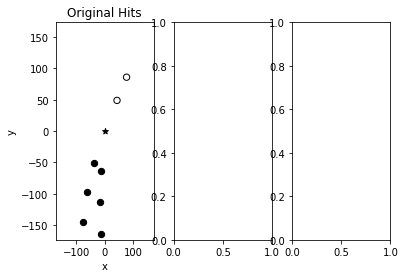

In [12]:
fig.gca().scatter([0], [0], marker="*", linestyle="None", color='black')
fig

Detector layers

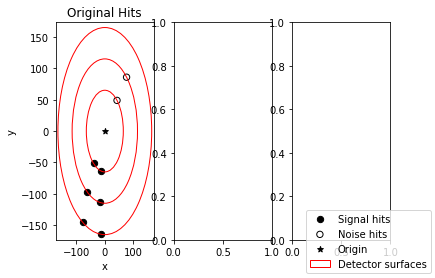

In [13]:
ly1 = plt.Circle((0, 0), detR[0], color='r', fill=False)
ly2 = plt.Circle((0, 0), detR[1], color='r', fill=False)
ly3 = plt.Circle((0, 0), detR[2], color='r', fill=False)

fig.gca().add_patch(ly1)
fig.gca().add_patch(ly2)
fig.gca().add_patch(ly3)

fig.legend(['Signal hits','Noise hits','Origin','Detector surfaces'], loc='lower right')

fig

lt.show()

Conformal mapping (translate circles passing through the origin to straight lines)
==========

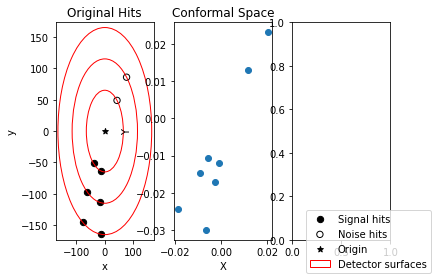

In [14]:
[cxHits, cyHits] = conformal(xHits, yHits)

#plt.subplot(1,3,2)
ax2.set_title('Conformal Space')

ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.scatter(cxHits, cyHits)
fig

Do Hough Transform
==========

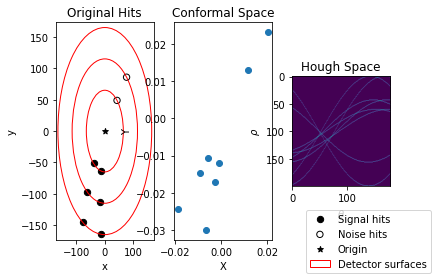

In [15]:
accumulator, thetas, rhos = houghLine(cxHits, cyHits)

#plt.subplot(1,3,3)
ax3.set_title('Hough Space')
ax3.set_xlabel(r'$\theta$')
ax3.set_ylabel(r'$\rho$')
ax3.imshow(accumulator)
fig

lt.set_cmap('gray')

In [16]:
plt.savefig('demo_hough_transform_circles_1.png')
fig
plt.show()

<Figure size 432x288 with 0 Axes>

Draw all canvases 

In [17]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()